In [ ]:
# On dreamer and game dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import scipy
from scipy.io import loadmat
import os

import time
from sklearn.svm import SVC
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from math import log


import tensorflow as tf
import keras
from keras import layers

import seaborn as sns

In [ ]:
dreamer = pd.read_csv("/content/Dreamer_features.csv")
game_features = pd.read_csv("/content/GE_Features.csv")
game_labels = pd.read_csv("/content/game_labels.csv")

In [ ]:
dreamer

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature1002,Feature1003,Feature1004,Feature1005,Feature1006,Feature1007,Feature1008,Valence,Arousal,Dominance
0,0.403312,-1.135786,0.799996,0.328325,-5.032911,0.231830,0.351055,0.888516,0.740776,-0.108014,...,0.906543,0.830883,0.830883,0.830883,1.156771,1.156771,1.156771,4,3,2
1,-0.184451,-1.006159,0.101853,0.028146,-0.208794,-0.245158,0.026495,0.243053,0.124150,-0.174223,...,0.716258,0.820666,0.820666,0.820666,1.132149,1.132149,1.132149,3,3,1
2,-11.154766,0.379181,0.679086,0.574405,-4.602925,0.025136,0.491954,1.018195,1.209957,0.404338,...,1.055392,1.069116,1.069116,1.069116,1.621586,1.621586,1.621586,5,4,4
3,0.170487,1.773795,0.151326,0.044994,0.359494,0.190507,-0.256227,0.217315,0.069563,0.211130,...,0.999461,0.829114,0.829114,0.829114,0.941613,0.941613,0.941613,4,3,2
4,0.928897,14.690810,0.911509,0.527863,4.796648,0.994842,-0.001293,0.480666,0.250301,34.969906,...,0.811895,0.754691,0.754691,0.754691,0.662956,0.662956,0.662956,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,5.562394,3.307369,2.063835,4.142882,0.467265,-1.281180,-2.304695,0.929342,1.169795,-1.667185,...,1.281171,1.174404,1.174404,1.174404,1.214847,1.214847,1.214847,2,2,2
410,-1.238679,0.112911,0.689555,0.518028,-5.226477,1.175509,1.818646,2.184856,2.921554,1.588299,...,1.234357,1.178726,1.178726,1.178726,1.286491,1.286491,1.286491,2,2,2
411,-2.639678,-2.362744,1.287274,2.851073,-0.965680,-5.205637,-0.361874,2.990372,3.997990,-1.381933,...,1.153588,1.099545,1.099545,1.099545,1.216319,1.216319,1.216319,3,3,2
412,1.400735,-0.140658,1.056458,1.449683,1.339741,-0.174475,-0.169927,1.312407,1.795751,-0.037234,...,0.939035,1.246725,1.246725,1.246725,1.295985,1.295985,1.295985,2,2,4


In [ ]:
# 0 - boring
# 1 - calm
# 2 - horror
# 3 - happy
def Make_Labels(valence, arousal):
  x = []
  for i in range(len(valence)):
    v = valence[i]
    a = arousal[i]

    if v == 0 and a == 0:
      x.append(0)
    elif v== 1 and a == 0:
      x.append(1)
    elif v== 0 and a == 1:
      x.append(2)
    elif v== 1 and a == 1:
      x.append(3)

  return np.array(x)

In [ ]:
#@title Dreamer
dreamer_features = dreamer.drop(["Valence", "Arousal", "Dominance"], axis=1)
dreamer_labels = dreamer[["Valence", "Arousal", "Dominance"]]

# creating dreamer labels
valence = []
arousal = []
for i in range(dreamer_labels.shape[0]):
  v = dreamer_labels.iloc[i, 0]
  a = dreamer_labels.iloc[i, 1]

  valence.append( 1 if v>3 else 0 )
  arousal.append( 1 if a>3 else 0 )

dreamer_labels =  Make_Labels(valence, arousal)

In [ ]:
dreamer_features

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature999,Feature1000,Feature1001,Feature1002,Feature1003,Feature1004,Feature1005,Feature1006,Feature1007,Feature1008
0,0.403312,-1.135786,0.799996,0.328325,-5.032911,0.231830,0.351055,0.888516,0.740776,-0.108014,...,0.778788,0.906543,0.906543,0.906543,0.830883,0.830883,0.830883,1.156771,1.156771,1.156771
1,-0.184451,-1.006159,0.101853,0.028146,-0.208794,-0.245158,0.026495,0.243053,0.124150,-0.174223,...,0.719271,0.716258,0.716258,0.716258,0.820666,0.820666,0.820666,1.132149,1.132149,1.132149
2,-11.154766,0.379181,0.679086,0.574405,-4.602925,0.025136,0.491954,1.018195,1.209957,0.404338,...,0.866318,1.055392,1.055392,1.055392,1.069116,1.069116,1.069116,1.621586,1.621586,1.621586
3,0.170487,1.773795,0.151326,0.044994,0.359494,0.190507,-0.256227,0.217315,0.069563,0.211130,...,1.124805,0.999461,0.999461,0.999461,0.829114,0.829114,0.829114,0.941613,0.941613,0.941613
4,0.928897,14.690810,0.911509,0.527863,4.796648,0.994842,-0.001293,0.480666,0.250301,34.969906,...,0.712500,0.811895,0.811895,0.811895,0.754691,0.754691,0.754691,0.662956,0.662956,0.662956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,5.562394,3.307369,2.063835,4.142882,0.467265,-1.281180,-2.304695,0.929342,1.169795,-1.667185,...,1.070176,1.281171,1.281171,1.281171,1.174404,1.174404,1.174404,1.214847,1.214847,1.214847
410,-1.238679,0.112911,0.689555,0.518028,-5.226477,1.175509,1.818646,2.184856,2.921554,1.588299,...,1.131221,1.234357,1.234357,1.234357,1.178726,1.178726,1.178726,1.286491,1.286491,1.286491
411,-2.639678,-2.362744,1.287274,2.851073,-0.965680,-5.205637,-0.361874,2.990372,3.997990,-1.381933,...,0.834902,1.153588,1.153588,1.153588,1.099545,1.099545,1.099545,1.216319,1.216319,1.216319
412,1.400735,-0.140658,1.056458,1.449683,1.339741,-0.174475,-0.169927,1.312407,1.795751,-0.037234,...,0.872762,0.939035,0.939035,0.939035,1.246725,1.246725,1.246725,1.295985,1.295985,1.295985


In [ ]:
dreamer_labels

array([1, 0, 3, 1, 3, 0, 3, 0, 0, 1, 1, 1, 1, 0, 2, 0, 0, 2, 0, 2, 3, 2,
       0, 0, 1, 2, 0, 2, 1, 1, 3, 0, 2, 2, 0, 2, 2, 3, 3, 2, 2, 0, 1, 2,
       0, 0, 1, 1, 3, 0, 1, 1, 0, 0, 0, 0, 3, 2, 1, 3, 1, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 3, 2, 0, 0, 1, 2, 0, 0, 1, 1, 3, 0, 0, 2,
       2, 2, 0, 2, 3, 2, 3, 2, 1, 2, 2, 2, 1, 1, 3, 0, 0, 3, 2, 3, 0, 0,
       1, 2, 2, 2, 3, 2, 2, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 2, 1, 2, 0, 3,
       0, 0, 0, 1, 1, 0, 3, 0, 0, 1, 0, 2, 0, 3, 3, 2, 3, 2, 3, 0, 2, 2,
       1, 1, 3, 0, 2, 3, 2, 2, 1, 0, 1, 3, 3, 3, 3, 0, 0, 1, 1, 1, 3, 0,
       0, 3, 0, 3, 0, 2, 3, 2, 3, 0, 1, 2, 0, 2, 1, 1, 3, 0, 0, 0, 0, 0,
       1, 0, 1, 2, 1, 3, 3, 2, 2, 2, 1, 1, 3, 0, 2, 1, 0, 0, 1, 1, 3, 3,
       3, 2, 1, 2, 0, 2, 0, 1, 3, 0, 0, 1, 0, 3, 0, 1, 3, 0, 3, 3, 3, 2,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 3, 2, 2, 2, 1, 2, 0, 2, 0, 1,
       1, 0, 2, 3, 0, 2, 0, 0, 3, 2, 0, 2, 3, 2, 0, 0, 1, 1, 3, 0, 0, 3,
       0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 0, 1, 1, 1,

In [ ]:
np.unique(dreamer_labels, return_counts=True)

(array([0, 1, 2, 3]), array([146,  87, 105,  76]))

# Gameemo

In [ ]:
# boring, calm, horror, funny
valence = []
arousal = []
for i in range(game_labels.shape[0]):
  if "G1" in game_labels.iloc[i, 0]:
    valence.append(0)
    arousal.append(0)
  elif "G2" in game_labels.iloc[i, 0]:
    valence.append(1)
    arousal.append(0)
  elif "G3" in game_labels.iloc[i, 0]:
    valence.append(0)
    arousal.append(1)
  elif "G4" in game_labels.iloc[i, 0]:
    valence.append(1)
    arousal.append(1)


game_labels =  Make_Labels(valence, arousal)

In [ ]:
game_features

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature999,Feature1000,Feature1001,Feature1002,Feature1003,Feature1004,Feature1005,Feature1006,Feature1007,Feature1008
0,-0.021031,-0.042655,1.454461,0.250652,0.181332,-0.008090,0.002972,2.752933,0.978479,-0.054301,...,0.729799,1.021853,1.021853,1.021853,1.899937,1.899937,1.899937,0.170876,0.170876,0.170876
1,0.022676,0.033869,0.878150,0.076201,0.475411,0.001274,0.000551,1.454111,0.437283,-0.028487,...,0.728184,1.530953,1.530953,1.530953,2.342793,2.342793,2.342793,1.097684,1.097684,1.097684
2,-0.007288,-0.023437,0.641537,0.102115,0.035843,-0.009911,-0.000146,1.811834,0.782233,0.033891,...,1.156668,1.537271,1.537271,1.537271,2.257651,2.257651,2.257651,0.568895,0.568895,0.568895
3,-0.008712,0.002725,1.042179,0.253079,0.154961,0.005029,0.006564,1.974915,0.696094,0.030264,...,0.630816,0.927396,0.927396,0.927396,2.143695,2.143695,2.143695,0.568972,0.568972,0.568972
4,-0.168693,-0.009952,5.256357,3.614102,-0.947616,-0.083211,0.000062,3.764477,1.160935,-1.237345,...,-0.463758,0.177646,0.177646,0.177646,0.604055,0.604055,0.604055,-0.221306,-0.221306,-0.221306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.081130,0.005678,3.200436,0.856021,0.799078,0.052602,-0.000476,3.671650,1.326347,0.127956,...,0.567637,0.924675,0.924675,0.924675,1.512294,1.512294,1.512294,0.604172,0.604172,0.604172
108,0.249450,0.065912,9.881600,6.205606,1.216769,0.128844,0.018174,8.064923,3.372938,0.910611,...,0.128699,1.017714,1.017714,1.017714,1.439626,1.439626,1.439626,0.526743,0.526743,0.526743
109,-0.078477,0.003975,2.281026,1.465449,-0.236997,-0.041210,-0.109771,6.218491,4.487955,-0.040825,...,0.903366,1.656425,1.656425,1.656425,2.196166,2.196166,2.196166,0.815331,0.815331,0.815331
110,0.221613,0.081323,10.352891,8.215144,0.835974,0.136399,-0.113811,9.419235,8.601646,0.239621,...,0.854817,1.062286,1.062286,1.062286,1.806639,1.806639,1.806639,0.774411,0.774411,0.774411


In [ ]:
game_labels

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
       0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
       0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3])

In [ ]:
#@title Combining Features & labels
features = pd.concat([dreamer_features, game_features], axis=0, ignore_index=True)
features

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature999,Feature1000,Feature1001,Feature1002,Feature1003,Feature1004,Feature1005,Feature1006,Feature1007,Feature1008
0,0.403312,-1.135786,0.799996,0.328325,-5.032911,0.231830,0.351055,0.888516,0.740776,-0.108014,...,0.778788,0.906543,0.906543,0.906543,0.830883,0.830883,0.830883,1.156771,1.156771,1.156771
1,-0.184451,-1.006159,0.101853,0.028146,-0.208794,-0.245158,0.026495,0.243053,0.124150,-0.174223,...,0.719271,0.716258,0.716258,0.716258,0.820666,0.820666,0.820666,1.132149,1.132149,1.132149
2,-11.154766,0.379181,0.679086,0.574405,-4.602925,0.025136,0.491954,1.018195,1.209957,0.404338,...,0.866318,1.055392,1.055392,1.055392,1.069116,1.069116,1.069116,1.621586,1.621586,1.621586
3,0.170487,1.773795,0.151326,0.044994,0.359494,0.190507,-0.256227,0.217315,0.069563,0.211130,...,1.124805,0.999461,0.999461,0.999461,0.829114,0.829114,0.829114,0.941613,0.941613,0.941613
4,0.928897,14.690810,0.911509,0.527863,4.796648,0.994842,-0.001293,0.480666,0.250301,34.969906,...,0.712500,0.811895,0.811895,0.811895,0.754691,0.754691,0.754691,0.662956,0.662956,0.662956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,0.081130,0.005678,3.200436,0.856021,0.799078,0.052602,-0.000476,3.671650,1.326347,0.127956,...,0.567637,0.924675,0.924675,0.924675,1.512294,1.512294,1.512294,0.604172,0.604172,0.604172
522,0.249450,0.065912,9.881600,6.205606,1.216769,0.128844,0.018174,8.064923,3.372938,0.910611,...,0.128699,1.017714,1.017714,1.017714,1.439626,1.439626,1.439626,0.526743,0.526743,0.526743
523,-0.078477,0.003975,2.281026,1.465449,-0.236997,-0.041210,-0.109771,6.218491,4.487955,-0.040825,...,0.903366,1.656425,1.656425,1.656425,2.196166,2.196166,2.196166,0.815331,0.815331,0.815331
524,0.221613,0.081323,10.352891,8.215144,0.835974,0.136399,-0.113811,9.419235,8.601646,0.239621,...,0.854817,1.062286,1.062286,1.062286,1.806639,1.806639,1.806639,0.774411,0.774411,0.774411


In [ ]:
dreamer_labels

array([1, 0, 3, 1, 3, 0, 3, 0, 0, 1, 1, 1, 1, 0, 2, 0, 0, 2, 0, 2, 3, 2,
       0, 0, 1, 2, 0, 2, 1, 1, 3, 0, 2, 2, 0, 2, 2, 3, 3, 2, 2, 0, 1, 2,
       0, 0, 1, 1, 3, 0, 1, 1, 0, 0, 0, 0, 3, 2, 1, 3, 1, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 3, 2, 0, 0, 1, 2, 0, 0, 1, 1, 3, 0, 0, 2,
       2, 2, 0, 2, 3, 2, 3, 2, 1, 2, 2, 2, 1, 1, 3, 0, 0, 3, 2, 3, 0, 0,
       1, 2, 2, 2, 3, 2, 2, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 2, 1, 2, 0, 3,
       0, 0, 0, 1, 1, 0, 3, 0, 0, 1, 0, 2, 0, 3, 3, 2, 3, 2, 3, 0, 2, 2,
       1, 1, 3, 0, 2, 3, 2, 2, 1, 0, 1, 3, 3, 3, 3, 0, 0, 1, 1, 1, 3, 0,
       0, 3, 0, 3, 0, 2, 3, 2, 3, 0, 1, 2, 0, 2, 1, 1, 3, 0, 0, 0, 0, 0,
       1, 0, 1, 2, 1, 3, 3, 2, 2, 2, 1, 1, 3, 0, 2, 1, 0, 0, 1, 1, 3, 3,
       3, 2, 1, 2, 0, 2, 0, 1, 3, 0, 0, 1, 0, 3, 0, 1, 3, 0, 3, 3, 3, 2,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 3, 2, 2, 2, 1, 2, 0, 2, 0, 1,
       1, 0, 2, 3, 0, 2, 0, 0, 3, 2, 0, 2, 3, 2, 0, 0, 1, 1, 3, 0, 0, 3,
       0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 0, 1, 1, 1,

In [ ]:
labels = np.concatenate([dreamer_labels, game_labels])
labels

array([1, 0, 3, 1, 3, 0, 3, 0, 0, 1, 1, 1, 1, 0, 2, 0, 0, 2, 0, 2, 3, 2,
       0, 0, 1, 2, 0, 2, 1, 1, 3, 0, 2, 2, 0, 2, 2, 3, 3, 2, 2, 0, 1, 2,
       0, 0, 1, 1, 3, 0, 1, 1, 0, 0, 0, 0, 3, 2, 1, 3, 1, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 3, 2, 0, 0, 1, 2, 0, 0, 1, 1, 3, 0, 0, 2,
       2, 2, 0, 2, 3, 2, 3, 2, 1, 2, 2, 2, 1, 1, 3, 0, 0, 3, 2, 3, 0, 0,
       1, 2, 2, 2, 3, 2, 2, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 2, 1, 2, 0, 3,
       0, 0, 0, 1, 1, 0, 3, 0, 0, 1, 0, 2, 0, 3, 3, 2, 3, 2, 3, 0, 2, 2,
       1, 1, 3, 0, 2, 3, 2, 2, 1, 0, 1, 3, 3, 3, 3, 0, 0, 1, 1, 1, 3, 0,
       0, 3, 0, 3, 0, 2, 3, 2, 3, 0, 1, 2, 0, 2, 1, 1, 3, 0, 0, 0, 0, 0,
       1, 0, 1, 2, 1, 3, 3, 2, 2, 2, 1, 1, 3, 0, 2, 1, 0, 0, 1, 1, 3, 3,
       3, 2, 1, 2, 0, 2, 0, 1, 3, 0, 0, 1, 0, 3, 0, 1, 3, 0, 3, 3, 3, 2,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 3, 2, 2, 2, 1, 2, 0, 2, 0, 1,
       1, 0, 2, 3, 0, 2, 0, 0, 3, 2, 0, 2, 3, 2, 0, 0, 1, 1, 3, 0, 0, 3,
       0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 0, 1, 1, 1,

In [ ]:
x = np.unique(labels, return_counts=True)
print(x)

(array([0, 1, 2, 3]), array([174, 115, 133, 104]))


<BarContainer object of 4 artists>

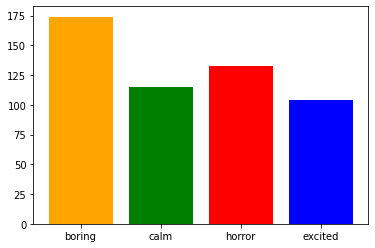

In [ ]:
plt.bar(["boring", "calm", "horror", "excited"], x[1], color=["orange", "green", "red", "blue"])

In [ ]:
#@title Graph Drawing
def display_learning_curves(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  ax1.plot(history.history["loss"])
  ax1.plot(history.history["val_loss"])
  ax1.legend(["train", "test"], loc="upper right")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")

  ax2.plot(history.history["acc"])
  ax2.plot(history.history["val_acc"])
  ax2.legend(["train", "test"], loc="upper right")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")
  plt.show()

def display_learning_curves2(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  ax1.plot(history.history["loss"])
  ax1.plot(history.history["val_loss"])
  ax1.legend(["train", "test"], loc="upper right")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")

  ax2.plot(history.history["accuracy"])
  ax2.plot(history.history["val_accuracy"])
  ax2.legend(["train", "test"], loc="upper right")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")
  plt.show()

In [ ]:
#@title Deep Learning model

# CNN
def CNN_Model(x_train):
  model = keras.Sequential(name="CNN")

  model.add(layers.Conv1D(32, kernel_size=3, activation="softmax", input_shape=x_train.shape[1:]))
  model.add(layers.Conv1D(64, kernel_size=3, activation="softmax"))
  model.add(layers.Conv1D(128, kernel_size=3, activation="softmax"))

  model.add(layers.Flatten())

  model.add(layers.Dense(64, activation="softmax"))
  model.add(layers.Dense(128, activation="softmax"))
  model.add(layers.Dense(4, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  model.summary()

  return model

def LSTM_Model(X_train):
  model = keras.Sequential(name="LSTM")

  model.add(layers.LSTM(5, return_sequences=True, input_shape=x_train.shape[1:]))
  model.add(layers.LSTM(8))

  model.add(layers.Dense(64, activation="softmax"))
  model.add(layers.Dense(128, activation="softmax"))
  model.add(layers.Dense(4, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  model.summary()

  return model


def MLP_Model(X_train):
  model = keras.Sequential(name="MLP")

  model.add(layers.Dense(64, activation="softmax", input_shape=x_train.shape[1:]))
  model.add(layers.Dense(128, activation="softmax"))
  model.add(layers.Dense(4, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  model.summary()

  return model

def CNN_LSTM_Model(x_train):
  model = keras.Sequential(name="CNN_LSTM")

  model.add(layers.Conv1D(32, kernel_size=3, activation="softmax", input_shape=x_train.shape[1:]))
  model.add(layers.Conv1D(64, kernel_size=3, activation="softmax"))
  model.add(layers.Conv1D(128, kernel_size=3, activation="softmax"))

  model.add(layers.LSTM(5, return_sequences=True))
  model.add(layers.LSTM(10))

  model.add(layers.Dense(64, activation="softmax"))
  model.add(layers.Dense(128, activation="relu"))
  model.add(layers.Dense(4, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  model.summary()

  return model

In [ ]:
#@title Change Dimension and Prepare Data
def Change_Dimension(x):

  print("shape of x", x.shape)

  if type(x) == "numpy.ndarray":
    raise Exception("To change dimensions array must be a numpy array")

  if len(x.shape) == 2:
    length = x.shape
    return x.reshape(length[0], length[1], 1)
  elif len(x.shape) == 3:
    length = x.shape
    return x.reshape(length[0], -1)


def Prepare_Data(x, y):
  shape = x.shape
  # x = x.reshape(shape[0], shape[1], 1)
  # x = x.to_numpy().reshape(shape[0], shape[1], 1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=2)

  print(x.shape)
  print(y.shape)
  print("shape of of x train: ", x_train.shape)
  print("shape of of x test: ", x_test.shape)
  print("shape of of y train: ", y_train.shape)
  print("shape of of y test: ", y_test.shape)
  print("y train unique values", np.unique(y_train, return_counts=True) )
  print("y test unique values", np.unique(y_test, return_counts=True) )

  return x_train, x_test, y_train, y_test



In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=30,
    restore_best_weights=True,
)

epochs = 100

In [ ]:
x_train, x_test, y_train, y_test = Prepare_Data(Change_Dimension(np.array(features)), np.array(labels))

shape of x (526, 1008)
(526, 1008, 1)
(526,)
shape of of x train:  (420, 1008, 1)
shape of of x test:  (106, 1008, 1)
shape of of y train:  (420,)
shape of of y test:  (106,)
y train unique values (array([0, 1, 2, 3]), array([140,  86, 111,  83]))
y test unique values (array([0, 1, 2, 3]), array([34, 29, 22, 21]))


# GCN

In [ ]:
#@title Make Sparse Matrix

def sparse_matrix(label):
  unique_values = np.unique(label)

  sparse_graph = {}
  for i in unique_values:
    sparse_graph[i] = []

  # print("sparse graph: ", sparse_graph)

  for index, i in enumerate(label):
    sparse_graph[i].append(index)
  
  # print("sparse graph: ", sparse_graph)

  source = []
  target = []

  for key in sparse_graph.keys():
    values = sparse_graph[key]
    for i in values:
      source.extend([i]*len(values))
      target.extend(values)

  return pd.DataFrame({
      "source": source,
      "target": target
  })



In [ ]:
#@title Creating the GCN Model

# Feedforward Network (FFN) Module
def create_ffn(hidden_units, dropout_rate, name=None):
  fnn_layers = []

  # fnn_layers.append(layers.Input())

  for units in hidden_units:
      # fnn_layers.append(layers.Conv1D(10, kernel_size=3))
      fnn_layers.append(layers.BatchNormalization())
      fnn_layers.append(layers.Dropout(dropout_rate))
      fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

  return keras.Sequential(fnn_layers, name=name)




  #@title
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)




#@title
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="mean",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        print("Point 2 ----------------------------------")
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create the third GraphConv layer.
        self.conv3 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv3",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        print("Point 1 .......................................")
        print(self.node_features.shape)
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Apply the third graph conv layer.
        x3 = self.conv3((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x3 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.

        print(input_node_indices)

        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


# hidden_units = [32, 32]
# learning_rate = 0.01
# dropout_rate = 0.5
# num_epochs = 300
# batch_size = 256

# gnn_model = GNNNodeClassifier(
#     graph_info=graph_info,
#     num_classes=classes,
#     hidden_units=hidden_units,
#     dropout_rate=dropout_rate,
#     name="gnn_model",
# )

# print("GNN output shape:", gnn_model([1, 10, 100]))

# gnn_model.summary()

# history = run_experiment(gnn_model, np.array(x_train), y_train)

In [ ]:
#@title Make Graph Details

def Make_Graph_Details(x, matrix):
  print("x shape:", x.shape)
  print(matrix.shape)

  edges = matrix.to_numpy().T

  edge_weight = tf.ones(shape=edges.shape[1])

  node_features = tf.cast(x, dtype=tf.dtypes.float32)

  graph_info = (node_features, edges, edge_weight)

  print( x.shape )
  print( edges.shape )
  print( edge_weight.shape )
  print( node_features.shape )
  print( len(graph_info) )

  return graph_info

In [ ]:
#@title Graph initialization
hidden_units = [32, 62]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 280
batch_size = 256

def Graph_Initialization(graph_info, labels):

  
  classes = len(np.unique(labels))

  gnn_model = GNNNodeClassifier(
      graph_info=graph_info,
      num_classes=classes,
      hidden_units=hidden_units,
      dropout_rate=dropout_rate,
      name="gnn_model",
  )

  print("GNN output shape:", gnn_model([1, 10, 100]))

  gnn_model.summary()

  return gnn_model


In [ ]:
#@title Run Experiment
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        # callbacks=[early_stopping],
    )

    return history

In [ ]:
features

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature999,Feature1000,Feature1001,Feature1002,Feature1003,Feature1004,Feature1005,Feature1006,Feature1007,Feature1008
0,0.403312,-1.135786,0.799996,0.328325,-5.032911,0.231830,0.351055,0.888516,0.740776,-0.108014,...,0.778788,0.906543,0.906543,0.906543,0.830883,0.830883,0.830883,1.156771,1.156771,1.156771
1,-0.184451,-1.006159,0.101853,0.028146,-0.208794,-0.245158,0.026495,0.243053,0.124150,-0.174223,...,0.719271,0.716258,0.716258,0.716258,0.820666,0.820666,0.820666,1.132149,1.132149,1.132149
2,-11.154766,0.379181,0.679086,0.574405,-4.602925,0.025136,0.491954,1.018195,1.209957,0.404338,...,0.866318,1.055392,1.055392,1.055392,1.069116,1.069116,1.069116,1.621586,1.621586,1.621586
3,0.170487,1.773795,0.151326,0.044994,0.359494,0.190507,-0.256227,0.217315,0.069563,0.211130,...,1.124805,0.999461,0.999461,0.999461,0.829114,0.829114,0.829114,0.941613,0.941613,0.941613
4,0.928897,14.690810,0.911509,0.527863,4.796648,0.994842,-0.001293,0.480666,0.250301,34.969906,...,0.712500,0.811895,0.811895,0.811895,0.754691,0.754691,0.754691,0.662956,0.662956,0.662956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,0.081130,0.005678,3.200436,0.856021,0.799078,0.052602,-0.000476,3.671650,1.326347,0.127956,...,0.567637,0.924675,0.924675,0.924675,1.512294,1.512294,1.512294,0.604172,0.604172,0.604172
522,0.249450,0.065912,9.881600,6.205606,1.216769,0.128844,0.018174,8.064923,3.372938,0.910611,...,0.128699,1.017714,1.017714,1.017714,1.439626,1.439626,1.439626,0.526743,0.526743,0.526743
523,-0.078477,0.003975,2.281026,1.465449,-0.236997,-0.041210,-0.109771,6.218491,4.487955,-0.040825,...,0.903366,1.656425,1.656425,1.656425,2.196166,2.196166,2.196166,0.815331,0.815331,0.815331
524,0.221613,0.081323,10.352891,8.215144,0.835974,0.136399,-0.113811,9.419235,8.601646,0.239621,...,0.854817,1.062286,1.062286,1.062286,1.806639,1.806639,1.806639,0.774411,0.774411,0.774411


In [ ]:
features.shape

(526, 1008)

In [ ]:
#@title Start GCN Start Here

# making sparse matrix
matrix = sparse_matrix(labels)

# cnn feature
features = layers.Conv1D(64, kernel_size=3, activation="relu")(Change_Dimension(features.to_numpy()))
features = layers.Conv1D(64, kernel_size=3, activation="relu")(features)
features = features.numpy()
shape = features.shape
features = pd.DataFrame(features.reshape(shape[0], shape[1]*shape[2]))
print("features shape", features.shape)

# make graph info using the matrix
graph_info = Make_Graph_Details(features, matrix)

# Initialize the Graph model
gnn_model = Graph_Initialization(graph_info, labels)

# Prepare Data
x_train, x_test, y_train, y_test = Prepare_Data(features, np.array(labels))

print("y train unique values: ", np.unique(y_train, return_counts=True))
print("y test unique values: ", np.unique(y_test, return_counts=True))
print("x train shape", x_train.shape)
print("x test shape", x_test.shape)
print("y train shape", y_train.shape)
print("y test shape", y_test.shape)

history = run_experiment(gnn_model, np.array(x_train.index), y_train)

shape of x (526, 1008)
features shape (526, 64256)
x shape: (526, 64256)
(72006, 2)
(526, 64256)
(2, 72006)
(72006,)
(526, 64256)
3
Point 2 ----------------------------------
Point 1 .......................................
(526, 64256)
[<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=10>, <tf.Tensor: shape=(), dtype=int32, numpy=100>]
GNN output shape: tf.Tensor(
[[-0.15916845  0.10129185  0.40784737  0.23836364]
 [-0.46466494  0.40228045 -0.5873846   0.3676384 ]
 [-0.04299441  0.06719008 -0.06646842 -0.04265581]], shape=(3, 4), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (526, 62)                 2315422   
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 11108     
 )                                                             

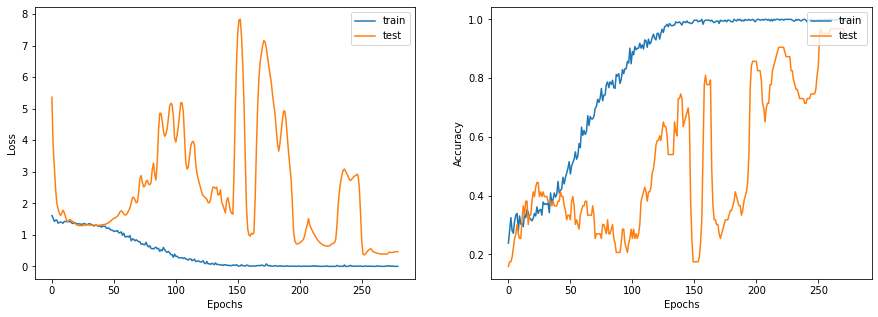

In [ ]:
display_learning_curves(history)

In [ ]:
gnn_model.evaluate(np.array(x_test.index), y_test)



4/4 [==============================] - 0s 15ms/step - loss: 0.6834 - acc: 0.9528


[0.683361291885376, 0.9528301954269409]

In [ ]:
pred_value = gnn_model.predict(np.array(x_test.index))

Point 1 .......................................
(526, 64256)
Tensor("IteratorGetNext:0", shape=(None,), dtype=int64)
4/4 [==============================] - 1s 12ms/step


In [ ]:
max_index = np.argmax(pred_value, axis=1)
max_index

array([2, 3, 2, 1, 0, 0, 3, 2, 0, 2, 0, 1, 0, 0, 3, 1, 3, 3, 2, 3, 1, 3,
       0, 2, 2, 0, 0, 1, 2, 3, 1, 1, 1, 2, 3, 0, 1, 0, 0, 0, 1, 1, 3, 1,
       0, 3, 2, 2, 1, 1, 1, 3, 0, 0, 3, 1, 0, 3, 1, 3, 0, 0, 3, 1, 2, 3,
       3, 3, 2, 0, 2, 2, 0, 1, 0, 0, 1, 0, 2, 3, 1, 1, 2, 0, 1, 0, 2, 2,
       1, 2, 0, 2, 0, 1, 3, 0, 3, 1, 0, 2, 0, 2, 2, 1, 1, 2])

In [ ]:
cf = confusion_matrix(y_test, max_index)

In [ ]:
print(cf)

[[31  1  2  0]
 [ 0 27  1  1]
 [ 0  0 22  0]
 [ 0  0  0 21]]


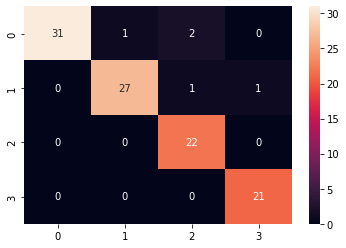

In [ ]:
sns.heatmap(cf, annot=True)

In [ ]:
print(classification_report(max_index, y_test))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        31
           1       0.93      0.96      0.95        28
           2       1.00      0.88      0.94        25
           3       1.00      0.95      0.98        22

    accuracy                           0.95       106
   macro avg       0.96      0.95      0.95       106
weighted avg       0.96      0.95      0.95       106



In [ ]:
x = gnn_model(x_train.index)

Point 1 .......................................
(526, 64256)
Int64Index([ 41, 216, 455, 228, 469, 155, 303, 320, 275, 428,
            ...
            287,  47, 433, 263, 360,  75, 466, 299, 493, 168],
           dtype='int64', length=420)


In [ ]:
x

<tf.Tensor: shape=(420, 4), dtype=float32, numpy=
array([[11.6132765 , -5.070503  , -3.1857634 , -5.6400676 ],
       [-6.3991523 , 19.066433  , -4.909671  ,  0.12484866],
       [-3.8008227 , 12.999112  , -4.4494705 ,  0.20389566],
       ...,
       [-2.3987095 , 11.0691805 , -5.0112495 ,  0.75285405],
       [-5.6564646 , -1.6854417 , -4.0024185 ,  9.63392   ],
       [-6.6337547 , -1.9134556 , -0.24698514,  9.092765  ]],
      dtype=float32)>